In [1]:
import numpy as np
import os

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, RandomSampler
from torchvision import transforms
from torchsummary import summary

import cv2
import random
from copy import deepcopy
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
from datetime import datetime 
from celluloid import Camera
from IPython.display import HTML

## Parameter

In [2]:
batch_size = 1
n_epochs = 200
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
lambda_l1 = 100

In [3]:
cuda = True if torch.cuda.is_available() else False
cuda

True

## Data

In [4]:
class Facade(Dataset):
  def __init__(self, path, transform = None):
    self.filenames = glob(path + '/*.jpg')
    self.transform = transform
  
  def __getitem__(self, idx):
    photoname = self.filenames[idx]
    sketchname = self.filenames[idx][:-3] + 'png'
    photo = Image.open(photoname).convert('RGB')
    sketch = Image.open(sketchname).convert('RGB')
    
    if self.transform:
      photo = self.transform(photo)
      sketch = self.transform(sketch)
    
    # jitter(randomcrop)
    i, j, h, w = transforms.RandomCrop.get_params(photo, output_size=(256, 256))
    photo = transforms.functional.crop(photo, i, j, h, w)
    sketch = transforms.functional.crop(sketch, i, j, h, w)
    
    # flip
    if random.random() > 0.5:
      photo = transforms.functional.hflip(photo)
      sketch = transforms.functional.hflip(sketch)
    
    return photo, sketch, (photoname, sketchname)
  
  def __len__(self):
    return len(self.filenames)

In [5]:
data_path = './Facade'


transform = transforms.Compose([
  transforms.Resize((286, 286)),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


dataset_Facade = Facade(path = data_path,
                        transform=transform)

dataloader = DataLoader(dataset=dataset_Facade,
                        batch_size=batch_size,
                        shuffle=True,
                        drop_last=True)

In [6]:
photo, sketch, file_names = next(iter(dataloader))

In [7]:
file_names

[('./Facade\\cmp_b0141.jpg',), ('./Facade\\cmp_b0141.png',)]

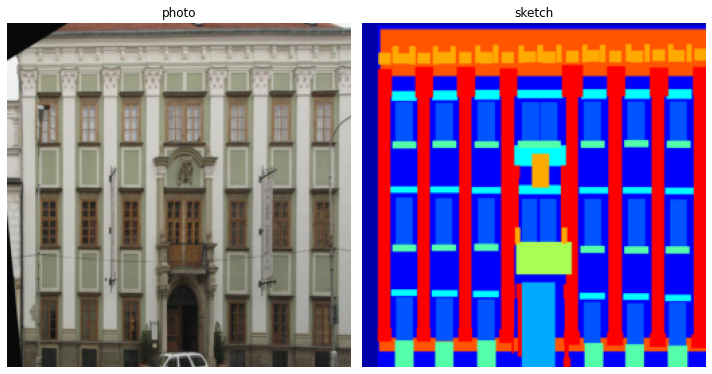

In [8]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(transforms.functional.to_pil_image(0.5 * photo[0] + 0.5))
plt.title('photo')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(transforms.functional.to_pil_image(0.5 * sketch[0] + 0.5))
plt.title('sketch')
plt.axis('off')

plt.tight_layout()
plt.savefig('./history/data.png', dpi=300)
plt.show()

## Model

In [9]:
def init_weight(module):
    classname = module.__class__.__name__

    if classname.find('Conv') != -1:
        nn.init.normal_(module.weight, mean=0.0, std=0.02)

In [10]:
class BlockCK(nn.Module):
  def __init__(self, in_ch, out_ch, is_encoder=True, is_batchnorm=True, is_dropout=False):
    super(BlockCK, self).__init__()

    self.is_encoder = is_encoder

    if is_encoder:
      conv = nn.Conv2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1)
      relu = nn.LeakyReLU(0.2)
    else:
      conv = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1)
      relu = nn.ReLU()

    batchnorm = nn.InstanceNorm2d(out_ch)
    dropout = nn.Dropout(0.5)

    model = [conv]

    if is_batchnorm:
      model += [batchnorm]
    if is_dropout:
      model += [dropout]

    model += [relu]

    self.model = nn.Sequential(*model)

  def forward(self, x, skip=None):
    if self.is_encoder:
      return self.model(x)
    else:
      return torch.cat((self.model(x), skip), 1)


class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    self.down_1_C64 = BlockCK(3, 64, is_batchnorm=False)
    self.down_2_C128 = BlockCK(64, 128)
    self.down_3_C256 = BlockCK(128, 256)
    self.down_4_C512 = BlockCK(256, 512)
    self.down_5_C512 = BlockCK(512, 512)
    self.down_6_C512 = BlockCK(512, 512)
    self.down_7_C512 = BlockCK(512, 512)
    self.down_8_C512 = BlockCK(512, 512, is_batchnorm=False)

    self.up_7_CD512 = BlockCK(512, 512, is_encoder=False, is_dropout=True)
    self.up_6_CD512 = BlockCK(1024, 512, is_encoder=False, is_dropout=True)
    self.up_5_CD512 = BlockCK(1024, 512, is_encoder=False, is_dropout=True)
    self.up_4_CD512 = BlockCK(1024, 512, is_encoder=False)
    self.up_3_C256 = BlockCK(1024, 256, is_encoder=False)
    self.up_2_C128 = BlockCK(512, 128, is_encoder=False)
    self.up_1_C64 = BlockCK(256, 64, is_encoder=False)

    self.conv = nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1)
    self.tan = nn.Tanh()

  def forward(self, x):
    down_1 = self.down_1_C64(x)
    down_2 = self.down_2_C128(down_1)
    down_3 = self.down_3_C256(down_2)
    down_4 = self.down_4_C512(down_3)
    down_5 = self.down_5_C512(down_4)
    down_6 = self.down_6_C512(down_5)
    down_7 = self.down_7_C512(down_6)
    down_8 = self.down_8_C512(down_7)

    up_7 = self.up_7_CD512(down_8, skip=down_7)
    up_6 = self.up_6_CD512(up_7, skip=down_6)
    up_5 = self.up_5_CD512(up_6, skip=down_5)
    up_4 = self.up_4_CD512(up_5, skip=down_4)
    up_3 = self.up_3_C256(up_4, skip=down_3)
    up_2 = self.up_2_C128(up_3, skip=down_2)
    up_1 = self.up_1_C64(up_2, skip=down_1)

    conv = self.conv(up_1)
    tan = self.tan(conv)

    return tan

In [11]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.model = nn.Sequential(
        nn.Conv2d(6, 64, kernel_size=4, stride=2, padding=1),
        nn.LeakyReLU(0.2),
        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
        nn.InstanceNorm2d(128),
        nn.LeakyReLU(0.2),
        nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
        nn.InstanceNorm2d(256),
        nn.LeakyReLU(0.2),
        nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
        nn.InstanceNorm2d(512),
        nn.LeakyReLU(0.2),
#         nn.Conv2d(512, 1, kernel_size=3, stride=1, padding=1),
        nn.ConvTranspose2d(512, 1, kernel_size=4, stride=4, dilation=3),
        nn.Sigmoid()
    )

  def forward(self, x, origin):
    return self.model(torch.cat((x, origin), 1))


In [12]:
generator = Generator()
discriminator = Discriminator()

generator.apply(init_weight)
discriminator.apply(init_weight)

Discriminator(
  (model): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2)
    (11): ConvTranspose2d(512, 1, kernel_size=(4, 4), stride=(4, 4), dilation=(3, 3))
    (12): Sigmoid()
  )
)

In [13]:
g_conv2d = generator.get_parameter('down_2_C128.model.0.weight')
print(g_conv2d.mean(), g_conv2d.std())

tensor(2.8030e-05, grad_fn=<MeanBackward0>) tensor(0.0200, grad_fn=<StdBackward0>)


In [14]:
generator.cuda()
discriminator.cuda()

Discriminator(
  (model): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2)
    (11): ConvTranspose2d(512, 1, kernel_size=(4, 4), stride=(4, 4), dilation=(3, 3))
    (12): Sigmoid()
  )
)

In [15]:
summary(discriminator, [(3, 256, 256), (3, 256, 256)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           6,208
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,200
    InstanceNorm2d-4          [-1, 128, 64, 64]               0
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,544
    InstanceNorm2d-7          [-1, 256, 32, 32]               0
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 16, 16]       2,097,664
   InstanceNorm2d-10          [-1, 512, 16, 16]               0
        LeakyReLU-11          [-1, 512, 16, 16]               0
  ConvTranspose2d-12            [-1, 1, 70, 70]           8,193
          Sigmoid-13            [-1, 1, 70, 70]               0
Total params: 2,767,809
Trainable param

## Train

In [16]:
history = {'D': [], 'G': []}
history_photo = []
history_loss = [0, 0]

ones = torch.ones(batch_size, 1, 70, 70).cuda()
ones.requires_grad = False
zeros = torch.zeros(batch_size, 1, 70, 70).cuda()
zeros.requires_grad = False

In [17]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

loss_gan = torch.nn.BCELoss()
loss_l1 = torch.nn.L1Loss()

In [18]:
loss_gan.cuda()
loss_l1.cuda()
sketch = sketch.cuda()

In [19]:
for epoch in range(n_epochs):
  time_start = datetime.now()
  history_loss = [0, 0]
  
  generator.train()
  for photos, sketches, _ in dataloader:
    
    photos = photos.cuda()
    sketches = sketches.cuda()

    '''
    Discriminator
    '''
    optimizer_D.zero_grad()

    # generate sketch
    photo_fake = generator(sketches)

    # discriminator classify photos
    D_real = discriminator(photos, sketches)
    D_fake = discriminator(photo_fake, sketches)
    
    # loss
    loss_real = loss_gan(D_real, ones)
    loss_fake = loss_gan(D_fake, zeros)
    loss_D = (loss_real + loss_fake) / 2
    history_loss[0] += loss_D.item()

    # update D
    loss_D.backward()
    optimizer_D.step()

    '''
    Generator
    '''
    optimizer_G.zero_grad()
    
    # generate image
    photo_fake = generator(sketches)

    # loss
    D_fake = discriminator(photo_fake, photos)
    
    loss_G = loss_gan(D_fake, ones) + lambda_l1 * loss_l1(photos, photo_fake)
    history_loss[1] += loss_G.item()

    # update G
    loss_G.backward()
    optimizer_G.step()

  '''
  History
  '''
  time_end = datetime.now() - time_start

  loss = [history_loss[0]/len(dataloader), history_loss[1]/len(dataloader)]
  history['D'].append(loss[0])
  history['G'].append(loss[1])
  
  generator.eval()
  
  
  with torch.no_grad():
    history_photo.append(generator(sketch))

  print('%2dM %2dS / Epoch %2d / loss_D: %.8f, loss_G: %.8f' %
        (*divmod(time_end.seconds, 60), (epoch+1), loss[0], loss[1]))


 0M 26S / Epoch  1 / loss_D: 0.56660322, loss_G: 33.08354211
 0M 26S / Epoch  2 / loss_D: 0.36840061, loss_G: 31.95189287
 0M 25S / Epoch  3 / loss_D: 0.29226475, loss_G: 31.56045040
 0M 25S / Epoch  4 / loss_D: 0.23869120, loss_G: 31.32344260
 0M 25S / Epoch  5 / loss_D: 0.22891833, loss_G: 31.12884400
 0M 25S / Epoch  6 / loss_D: 0.20762643, loss_G: 30.81668263
 0M 25S / Epoch  7 / loss_D: 0.20296938, loss_G: 30.57825262
 0M 25S / Epoch  8 / loss_D: 0.20001812, loss_G: 30.53432457
 0M 25S / Epoch  9 / loss_D: 0.17957635, loss_G: 30.25895910
 0M 25S / Epoch 10 / loss_D: 0.17623260, loss_G: 30.12243398
 0M 26S / Epoch 11 / loss_D: 0.17404255, loss_G: 29.92946030
 0M 25S / Epoch 12 / loss_D: 0.16635902, loss_G: 29.89432467
 0M 25S / Epoch 13 / loss_D: 0.18940102, loss_G: 29.60627614
 0M 25S / Epoch 14 / loss_D: 0.15168920, loss_G: 29.44539871
 0M 25S / Epoch 15 / loss_D: 0.15691628, loss_G: 29.42915717
 0M 25S / Epoch 16 / loss_D: 0.14216998, loss_G: 29.10171486
 0M 25S / Epoch 17 / los

## History

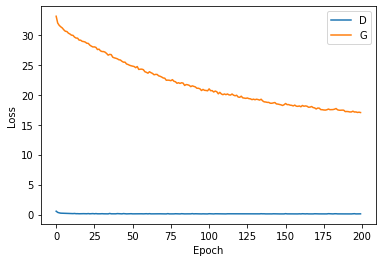

In [20]:
epoch = [i for i in range(n_epochs)]
plt.plot(epoch, history['D'])
plt.plot(epoch, history['G'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['D', 'G'])

plt.savefig('./history/history.png', dpi=300)
plt.show()

In [21]:
from matplotlib.animation import PillowWriter, FuncAnimation

<ipython-input-22-3c0b9e1ae50c>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_subplot(1, 3, 1)
<ipython-input-22-3c0b9e1ae50c>:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_subplot(1, 3, 2)
<ipython-input-22-3c0b9e1ae50c>:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be cr

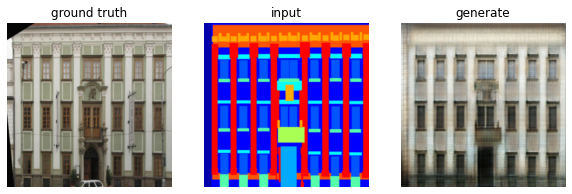

In [22]:
fig = plt.figure(figsize=(10, 5))
camera = Camera(fig)
photo_h = photo[0].permute(1, 2, 0).numpy()
photo_h = cv2.normalize(photo_h, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

sketch_h = sketch[0].detach().cpu().permute(1, 2, 0).numpy()
sketch_h = cv2.normalize(sketch_h, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

for epoch in range(n_epochs):
  fig.add_subplot(1, 3, 1)
  plt.axis('off')
  plt.title('ground truth')
  plt.imshow(photo_h)

  fig.add_subplot(1, 3, 2)
  plt.axis('off')
  plt.title('input')
  plt.imshow(sketch_h, label="input")

  fig.add_subplot(1, 3, 3)
  image = history_photo[epoch][0].detach().cpu().permute(1, 2, 0).numpy()
  image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
  plt.axis('off')
  plt.title('generate')
  plt.imshow(image, cmap='gray', label='generate')
  
  # fig.tight_layout()
  camera.snap()
animation = camera.animate(interval=100)
# animation.save('./history/history_result.gif', writer='imagemagick')
animation.save('./history/history_result.mp4', dpi=300)

HTML(animation.to_html5_video())

## Result
cmp_x0006  
cmp_x0031  
cmp_x0220  

In [24]:
transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [32]:
filename = 'cmp_x0220'
real = Image.open('./test/' +filename + '.jpg').convert('RGB')
test = Image.open('./test/' + filename + '.png').convert('RGB')
real = transform_test(real)
test = transform_test(test).unsqueeze(dim=0)

In [33]:
generator.eval()

with torch.no_grad():
  test_photo = generator(test.cuda())

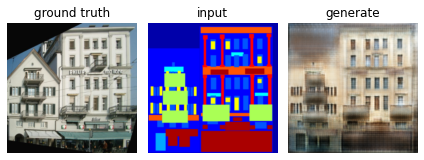

In [34]:
fig = plt.figure()

fig.add_subplot(1, 3, 1)
plt.axis('off')
plt.title('ground truth')
real = real.permute(1, 2, 0).numpy()
real = cv2.normalize(real, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
plt.imshow(real)

fig.add_subplot(1, 3, 2)
plt.axis('off')
test = test[0].detach().cpu().permute(1, 2, 0).numpy()
test = cv2.normalize(test, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
plt.title('input')
plt.imshow(test)

fig.add_subplot(1, 3, 3)
plt.axis('off')
test_photo = test_photo[0].detach().cpu().permute(1, 2, 0).numpy()
test_photo = cv2.normalize(test_photo, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
plt.title('generate')
plt.imshow(test_photo)

fig.tight_layout()
plt.savefig('./history/' + filename + '.png', dpi=300)

## Save

In [28]:
# torch.save(best_generator.state_dict(), './history/best_generator.pt')
torch.save(generator.state_dict(), './history/generator.pt')